<b><h2><center>WEED CLASSIFICATION</center></h2></b>

<center><img src="https://wildflowerfinder.org.uk/Flowers/C/Charlock/Charlock_2005_07_23_Nelson_canal_Burnley_003p1.jpg" width="600" height="450"></center>

Source: https://wildflowerfinder.org.uk/Flowers/C/Charlock/Charlock_2005_07_23_Nelson_canal_Burnley_003p1

# Import the required libraries

In [ ]:
# Basic libraries
import cv2
import numpy as np
import os

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam

# Plotting and visualizing images
import matplotlib.pyplot as plt


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### EXTRACT IMAGES AND LABELS FROM FOLDER LOCATIONS

In [2]:
import os
import cv2
import numpy as np

def load_dataset(folder_path):
    
    images = []
    labels = []

    # Get the list of subfolders (classes) in the folder path
    classes = os.listdir(folder_path)

    for class_name in classes:
        class_folder = os.path.join(folder_path, class_name)
        
        # Iterate through images in the class folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            images.append(image_path)
            labels.append(class_name)
    return np.array(images), np.array(labels)

# Path to the dataset folder
train_folder_path = r'C:\Users\OLASUNKANMI\Desktop\UoL DS Course files\Semester B\Image and Text Classification\Assessment 1\data-weed classification\train'
test_folder_path = r'C:\Users\OLASUNKANMI\Desktop\UoL DS Course files\Semester B\Image and Text Classification\Assessment 1\data-weed classification\test'
val_folder_path = r'C:\Users\OLASUNKANMI\Desktop\UoL DS Course files\Semester B\Image and Text Classification\Assessment 1\data-weed classification\val'

train_images, train_labels = load_dataset(train_folder_path)
test_images, test_labels = load_dataset(test_folder_path)
val_images, val_labels = load_dataset(val_folder_path)


print("Number of images in train dataset:", len(train_images))
print("Number of labels:", len(train_labels))
print("Number of images in test dataset:", len(test_images))
print("Number of labels:", len(test_labels))
print("Number of images in validation dataset:", len(val_images))
print("Number of labels:", len(val_labels))

Number of images in train dataset: 480
Number of labels: 480
Number of images in test dataset: 158
Number of labels: 158
Number of images in validation dataset: 148
Number of labels: 148


### IMAGE PREPROCESSING

-PREPROCESSING: 
    RESIZING ALL IMAGES TO 64 BY 64  and NOISE REMOVAL - DENOISING USING MEDIANBLUR

In [4]:
from sklearn.preprocessing import LabelEncoder
def preprocess_image(folder_path):

    image_preprocessed = []
    label_image =[]
    
    # Get the list of subfolders (classes) in the folder path
    classes = os.listdir(folder_path)

    for class_name in classes:
        class_folder = os.path.join(folder_path, class_name)
        
        # Iterate through images in the class folder
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            
            # Read the image_path as defined above - this will pass all images in each class folder - train, test, validation
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            
            # Resize the image
            image = cv2.resize(image,(64,64))
                
            # Denoising - Apply median blur for noise removal
            image = cv2.medianBlur(image, 7)  
                    
            # Append the preprocessed image and corresponding label to lists
            image_preprocessed.append(image)
            label_image.append(class_name)
            label_encoder = LabelEncoder()
            labels = label_encoder.fit_transform(label_image)

    return np.array(image_preprocessed), np.array(labels)

# Path to the dataset folder
train_folder_path = r'C:\Users\OLASUNKANMI\Desktop\UoL DS Course files\Semester B\Image and Text Classification\Assessment 1\data-weed classification\train'
test_folder_path = r'C:\Users\OLASUNKANMI\Desktop\UoL DS Course files\Semester B\Image and Text Classification\Assessment 1\data-weed classification\test'
val_folder_path = r'C:\Users\OLASUNKANMI\Desktop\UoL DS Course files\Semester B\Image and Text Classification\Assessment 1\data-weed classification\val'

# PREPROCESS THE DATA SET
train_images, train_labels = preprocess_image(train_folder_path)
test_images, test_labels = preprocess_image(test_folder_path)
val_images, val_labels = preprocess_image(val_folder_path)

### FEATURES EXTRACTION

FEATURES TO BE EXTRACTED ARE : RGB VALUES - USING THE MEAN RGB VALUES, COLOUR HISTOGRAM AND HISTOGRAM OF GRADIENT FEATURE

### FEATURE 1 - MEAN RGB VALUES

In [6]:
import numpy as np

def extract_mean_rgb_values(images):
    mean_rgb_values = []
    for image in images:
     # Compute the mean RGB value for the image
        mean_rgb = np.mean(image, axis=(0, 1))
        
        # Append the mean RGB value to the empty list above
        mean_rgb_values.append(mean_rgb)

    return mean_rgb_values

mean_rgb_values_train = extract_mean_rgb_values(train_images)
mean_rgb_values_test = extract_mean_rgb_values(test_images)
mean_rgb_values_val = extract_mean_rgb_values(val_images)

### FEATURE 2 - COLOUR HISTOGRAM

In [7]:
import cv2
import numpy as np

def extract_color_histograms(images, bins=(8, 8, 8)):
    histograms = []
    for image in images:
        # Convert the image to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        # Calculate the histogram for each channel
        hist_hue = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 256])
        hist_saturation = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
        hist_value = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])
        # Concatenate the histograms
        histogram = np.concatenate((hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()))
        # Normalize the histogram
        histogram /= (image.shape[0] * image.shape[1])  # Normalize by the image size
        histograms.append(histogram)
    return histograms

# Extract color histogram features
histograms_train = extract_color_histograms(train_images)
histograms_test = extract_color_histograms(test_images)
histograms_val = extract_color_histograms(val_images)

### FEATURE 3 - HISTOGRAM OF GRADIENT (HOG)

In [8]:
from skimage.feature import hog
from skimage import exposure

def extract_hog_features(images):
    hog_features = []
    for image in images:
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Calculate the HOG features
        hog_feature_vector, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        # Append the HOG feature vector to the list
        hog_features.append(hog_feature_vector)
    return hog_features

# Extract HOG features
hog_features_train = extract_hog_features(train_images)
hog_features_test = extract_hog_features(test_images)
hog_features_val = extract_hog_features(val_images)

### CONCATENATING THE THREE FEATURES TO TRAIN THE MODELS

In [9]:
import numpy as np

# Concatenate the three features for training data
train_features = np.concatenate((mean_rgb_values_train, histograms_train, hog_features_train), axis=1)

# Concatenate the three features for test data
test_features = np.concatenate((mean_rgb_values_test, histograms_test, hog_features_test), axis=1)

# Concatenate the three features for validation data
val_features = np.concatenate((mean_rgb_values_val, histograms_val, hog_features_val), axis=1)

# MACHINE LEARNING ALGORITHMS

#### 1 - SUPPORT VECTOR MACHINE - HYPERPARAMETER TUNING ( TRAINING - VALIDATION - TESTING CYCLE)

In [10]:
# Hyperparameter was tuned using a 5 fold cross validation to select the best parameter using the validation data and then the final 
# evaluation on the test data using the best parameter from the hyperparameter tuning.
# the best model's performance on the validation set using accuracy_score was used to assess
# its performance before testing it on the test set.

In [11]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Best Hyperparameters: {'C': 10, 'gamma': 0.001}
Validation Accuracy: 0.8445945945945946
Test Accuracy: 0.8481012658227848
Confusion Matrix:
[[83  7]
 [17 51]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        90
           1       0.88      0.75      0.81        68

    accuracy                           0.85       158
   macro avg       0.85      0.84      0.84       158
weighted avg       0.85      0.85      0.85       158



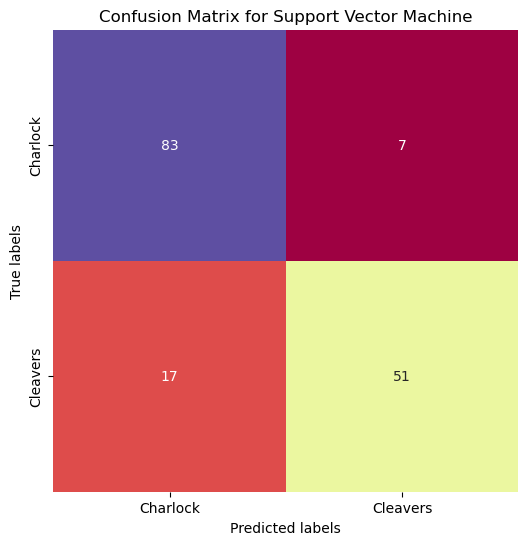

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [0.001, 0.01, 0.1] 
}

# Initialize model (SVM classifier)
svm = SVC()

#  GridSearchCV with the model and hyperparameters grid using 5 fold cross validation
grid_search = GridSearchCV(svm, param_grid, cv=5)

# fitting the model on training data
grid_search.fit(train_features, train_labels)

# the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model using the best hyperparameters on the entire training data
best_svm = SVC(**best_params)
best_svm.fit(train_features, train_labels)

# Evaluate the final model on the validation data
validation_accuracy = best_svm.score(val_features, val_labels)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the final model on the test data
test_accuracy = best_svm.score(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Calculate and print the confusion matrix on the test data
test_predictions = best_svm.predict(test_features)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Spectral", cbar=False, 
            xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()

#### 2 - LOGISTIC REGRESSION - HYPERPARAMETER TUNING ( TRAINING - VALIDATION - TESTING CYCLE)

In [13]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Best Hyperparameters: {'C': 0.1, 'solver': 'lbfgs'}
Validation Accuracy: 0.8513513513513513
Test Accuracy: 0.8860759493670886
Confusion Matrix:
[[84  6]
 [12 56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        90
           1       0.90      0.82      0.86        68

    accuracy                           0.89       158
   macro avg       0.89      0.88      0.88       158
weighted avg       0.89      0.89      0.89       158



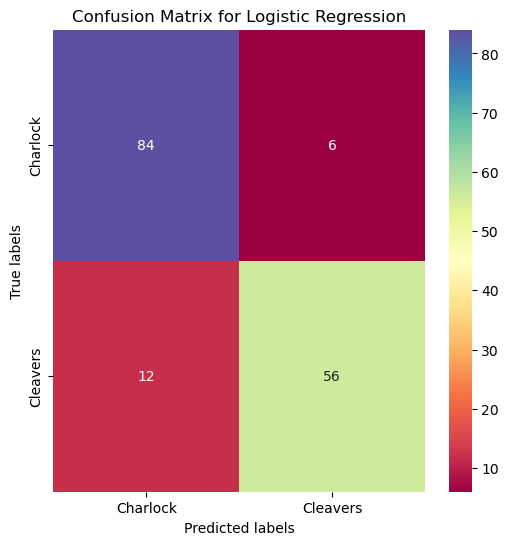

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga']
    
}

# Initialize model (Logistic Regression classifier)
log_reg = LogisticRegression(max_iter = 1000)

#  GridSearchCV with the model and hyperparameters grid using 5 fold cross validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5)

# fitting the model on training data
grid_search.fit(train_features, train_labels)

# the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model using the best hyperparameters on the entire training data
best_log_reg = LogisticRegression(**best_params)
best_log_reg.fit(train_features, train_labels)

# Evaluate the final model on the validation data
validation_accuracy = best_log_reg.score(val_features, val_labels)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the final model on the test data
test_accuracy = best_log_reg.score(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Calculate and print the confusion matrix on the test data
test_predictions = best_log_reg.predict(test_features)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Spectral", 
            xticklabels = ['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

#### 3 - KNN -  HYPERPARAMETER TUNING ( TRAINING - VALIDATION - TESTING CYCLE)

In [15]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}
Validation Accuracy: 0.8175675675675675
Test Accuracy: 0.7848101265822784
Confusion Matrix:
[[79 11]
 [23 45]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        90
           1       0.80      0.66      0.73        68

    accuracy                           0.78       158
   macro avg       0.79      0.77      0.77       158
weighted avg       0.79      0.78      0.78       158



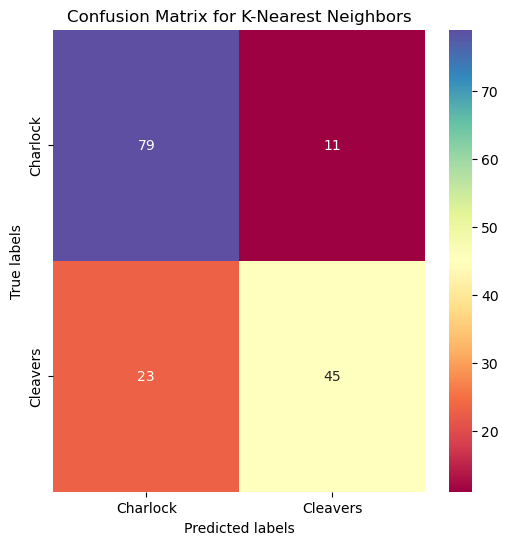

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Initialize model (K-Nearest Neighbors classifier)
knn = KNeighborsClassifier()

#  GridSearchCV with the model and hyperparameters grid using 5 fold cross validation
grid_search = GridSearchCV(knn, param_grid, cv=5)

# fitting the model on training data
grid_search.fit(train_features, train_labels)

# the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model using the best hyperparameters on the entire training data
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(train_features, train_labels)

# Evaluate the final model on the validation data
validation_accuracy = best_knn.score(val_features, val_labels)
print("Validation Accuracy:", validation_accuracy)

# Evaluate the final model on the test data
test_accuracy = best_knn.score(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Calculate and print the confusion matrix on the test data
test_predictions = best_knn.predict(test_features)
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report on the test data
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Spectral",
            xticklabels = ['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.show()

# DEEP LEARNING ALGORITHMS

In [17]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### FULLY CONNECTED NEURAL NETWORK

Epoch 1/15
15/15 [==============================] - 6s 50ms/step - loss: 0.6066 - accuracy: 0.6979 - val_loss: 0.5124 - val_accuracy: 0.7905
Epoch 2/15
15/15 [==============================] - 0s 9ms/step - loss: 0.4506 - accuracy: 0.8208 - val_loss: 0.4318 - val_accuracy: 0.8176
Epoch 3/15
15/15 [==============================] - 0s 6ms/step - loss: 0.3678 - accuracy: 0.8542 - val_loss: 0.3823 - val_accuracy: 0.8176
Epoch 4/15
15/15 [==============================] - 0s 7ms/step - loss: 0.3114 - accuracy: 0.8813 - val_loss: 0.3579 - val_accuracy: 0.8446
Epoch 5/15
15/15 [==============================] - 0s 7ms/step - loss: 0.2712 - accuracy: 0.9021 - val_loss: 0.3303 - val_accuracy: 0.8581
Epoch 6/15
15/15 [==============================] - 0s 7ms/step - loss: 0.2502 - accuracy: 0.9062 - val_loss: 0.3328 - val_accuracy: 0.8378
Epoch 7/15
15/15 [==============================] - 0s 7ms/step - loss: 0.2308 - accuracy: 0.9083 - val_loss: 0.3340 - val_accuracy: 0.8581
Epoch 8/15
15/15 [=

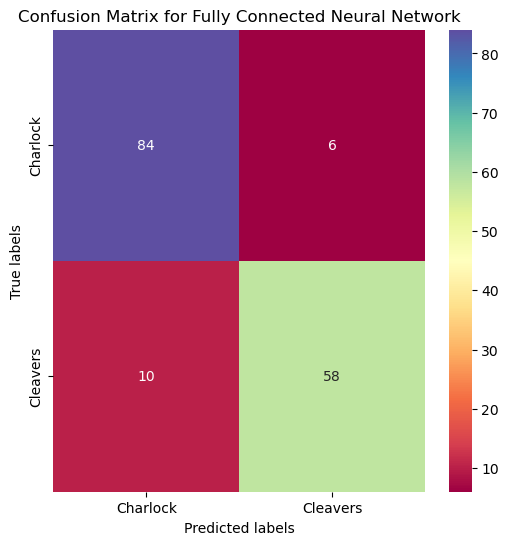

In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical

# Training the fully connected neural network with the color histogram feature above
histograms_train = np.array(histograms_train)
histograms_test = np.array(histograms_test)
histograms_val = np.array(histograms_val)

# Reshape histograms to make them compatible with the neural network
histograms_train_flattened = histograms_train.reshape(histograms_train.shape[0], -1)
histograms_test_flattened = histograms_test.reshape(histograms_test.shape[0], -1)
histograms_val_flattened = histograms_val.reshape(histograms_val.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(histograms_train_flattened)
test_features_scaled = scaler.transform(histograms_test_flattened)
val_features_scaled = scaler.transform(histograms_val_flattened)

# Define a simple fully connected neural network
model_fcnn = Sequential([
    Dense(128, activation='relu', input_shape=(train_features_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_fcnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_fcnn.fit(train_features_scaled, train_labels, epochs=15, batch_size=32, validation_data=(val_features_scaled, val_labels))

# Evaluate the model on the test data
test_loss, test_accuracy = model_fcnn.evaluate(test_features_scaled, test_labels)
print("Test Accuracy:", test_accuracy)

# Predict on the test data
test_predictions = np.round(model_fcnn.predict(test_features_scaled)).flatten()

# Print classification report
target_names = ['charlock', 'cleavers']
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names= target_names))

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Spectral", xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fully Connected Neural Network')
plt.show()

In [21]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### FULLY CONNECTED NEURAL NETWORK 2 (Model Improvement: learning rate = 0.0001)

Epoch 1/15
15/15 [==============================] - 2s 33ms/step - loss: 0.6066 - accuracy: 0.6979 - val_loss: 0.5124 - val_accuracy: 0.7905
Epoch 2/15
15/15 [==============================] - 0s 9ms/step - loss: 0.4506 - accuracy: 0.8208 - val_loss: 0.4318 - val_accuracy: 0.8176
Epoch 3/15
15/15 [==============================] - 0s 7ms/step - loss: 0.3678 - accuracy: 0.8542 - val_loss: 0.3823 - val_accuracy: 0.8176
Epoch 4/15
15/15 [==============================] - 0s 8ms/step - loss: 0.3114 - accuracy: 0.8813 - val_loss: 0.3579 - val_accuracy: 0.8446
Epoch 5/15
15/15 [==============================] - 0s 10ms/step - loss: 0.2712 - accuracy: 0.9021 - val_loss: 0.3303 - val_accuracy: 0.8581
Epoch 6/15
15/15 [==============================] - 0s 10ms/step - loss: 0.2502 - accuracy: 0.9062 - val_loss: 0.3328 - val_accuracy: 0.8378
Epoch 7/15
15/15 [==============================] - 0s 8ms/step - loss: 0.2308 - accuracy: 0.9083 - val_loss: 0.3340 - val_accuracy: 0.8581
Epoch 8/15
15/15 

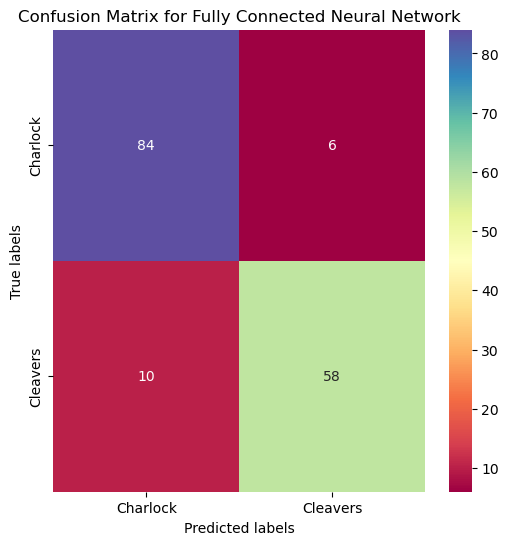

In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical

# Training the fully connected neural network with the color histogram feature above
histograms_train = np.array(histograms_train)
histograms_test = np.array(histograms_test)
histograms_val = np.array(histograms_val)

# Reshape histograms to make them compatible with the neural network
histograms_train_flattened = histograms_train.reshape(histograms_train.shape[0], -1)
histograms_test_flattened = histograms_test.reshape(histograms_test.shape[0], -1)
histograms_val_flattened = histograms_val.reshape(histograms_val.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(histograms_train_flattened)
test_features_scaled = scaler.transform(histograms_test_flattened)
val_features_scaled = scaler.transform(histograms_val_flattened)

# Define a simple fully connected neural network
model_fcnn2 = Sequential([
    Dense(128, activation='relu', input_shape=(train_features_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# for model improvement
adam = Adam(learning_rate=0.0001)

# Compile the model
model_fcnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_fcnn2.fit(train_features_scaled, train_labels, epochs=15, batch_size=32, validation_data=(val_features_scaled, val_labels))

# Evaluate the model on the test data
test_loss, test_accuracy = model_fcnn2.evaluate(test_features_scaled, test_labels)
print("Test Accuracy:", test_accuracy)

# Predict on the test data
test_predictions = np.round(model_fcnn2.predict(test_features_scaled)).flatten()

# Print classification report
target_names = ['charlock', 'cleavers']
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names= target_names))

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Spectral", xticklabels=['Charlock', 'Cleavers'], yticklabels=['Charlock', 'Cleavers'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fully Connected Neural Network')
plt.show()

### CONVOLUTIONAL NEURAL NETWORK (Using default architecture/parameters)

Epoch 1/15
15/15 [==============================] - 9s 389ms/step - loss: 3.7315 - accuracy: 0.5562 - val_loss: 0.6353 - val_accuracy: 0.7500
Epoch 2/15
15/15 [==============================] - 6s 387ms/step - loss: 0.5965 - accuracy: 0.6958 - val_loss: 0.7129 - val_accuracy: 0.5000
Epoch 3/15
15/15 [==============================] - 6s 400ms/step - loss: 0.5584 - accuracy: 0.7021 - val_loss: 0.4589 - val_accuracy: 0.7905
Epoch 4/15
15/15 [==============================] - 6s 398ms/step - loss: 0.4116 - accuracy: 0.8104 - val_loss: 0.4136 - val_accuracy: 0.8108
Epoch 5/15
15/15 [==============================] - 6s 404ms/step - loss: 0.2868 - accuracy: 0.8729 - val_loss: 0.2493 - val_accuracy: 0.8716
Epoch 6/15
15/15 [==============================] - 6s 410ms/step - loss: 0.1707 - accuracy: 0.9312 - val_loss: 0.4701 - val_accuracy: 0.8243
Epoch 7/15
15/15 [==============================] - 6s 436ms/step - loss: 0.1500 - accuracy: 0.9438 - val_loss: 0.5414 - val_accuracy: 0.8378
Epoch 

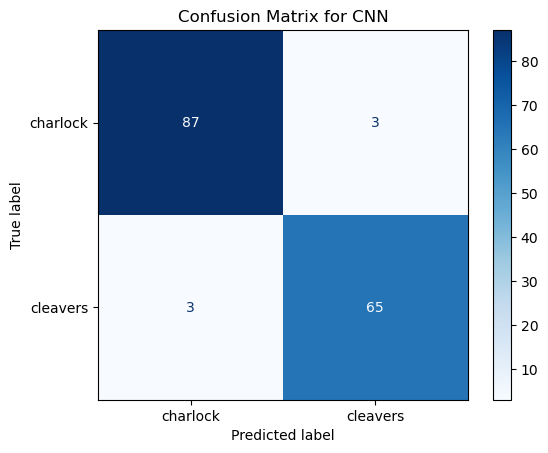

In [24]:
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Define the CNN model
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu')
    ])
    return model

# Define the model input shapes
input_shape = (64, 64, 3)  
num_classes = 2 
num_bins = 8  

# Create the CNN model
cnn_model = create_model(input_shape)

# Define input layer for images
input_img = layers.Input(shape=input_shape)

# Pass input_img through the CNN model
cnn_output = cnn_model(input_img)

# Define input layer for color histogram features
input_hist = layers.Input(shape=(num_bins * 3,))  

# Concatenate CNN output with color histogram features
concatenated = layers.concatenate([cnn_output, input_hist])

# more dense layers for classification
concatenated = layers.Dense(512, activation='relu')(concatenated)
output = layers.Dense(1, activation='sigmoid')(concatenated)

# the final model
model = models.Model(inputs=[input_img, input_hist], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
history_cnn = model.fit(
    [train_images, histograms_train], train_labels,
    epochs=15,
    validation_data=([val_images, histograms_val], val_labels),
    shuffle=True,  # Shuffle the training data with a fixed seed
    verbose=1  # Suppress the training output for cleaner display
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([test_images, histograms_test], test_labels)
print('Test accuracy:', test_acc)

# Predict labels for the test set
y_pred = model.predict([test_images, histograms_test]).flatten()
y_pred = np.round(y_pred)

# Print classification report
target_names= ['charlock', 'cleavers']
print(classification_report(test_labels, y_pred, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["charlock", "cleavers"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN')
plt.show()

### CONVOLUTIONAL NEURAL NETWORK 2 (adam = Adam(learning_rate=0.0001 for model improvement)

Epoch 1/15
15/15 [==============================] - 10s 457ms/step - loss: 2.8279 - accuracy: 0.5583 - val_loss: 0.6706 - val_accuracy: 0.5203
Epoch 2/15
15/15 [==============================] - 7s 440ms/step - loss: 0.5908 - accuracy: 0.6917 - val_loss: 0.4870 - val_accuracy: 0.7973
Epoch 3/15
15/15 [==============================] - 7s 458ms/step - loss: 0.4600 - accuracy: 0.7937 - val_loss: 0.4336 - val_accuracy: 0.7838
Epoch 4/15
15/15 [==============================] - 7s 460ms/step - loss: 0.3240 - accuracy: 0.8667 - val_loss: 0.2841 - val_accuracy: 0.8851
Epoch 5/15
15/15 [==============================] - 7s 464ms/step - loss: 0.2003 - accuracy: 0.9333 - val_loss: 0.2251 - val_accuracy: 0.9054
Epoch 6/15
15/15 [==============================] - 7s 478ms/step - loss: 0.1584 - accuracy: 0.9417 - val_loss: 0.3359 - val_accuracy: 0.8243
Epoch 7/15
15/15 [==============================] - 7s 487ms/step - loss: 0.1054 - accuracy: 0.9604 - val_loss: 0.2411 - val_accuracy: 0.9189
Epoch

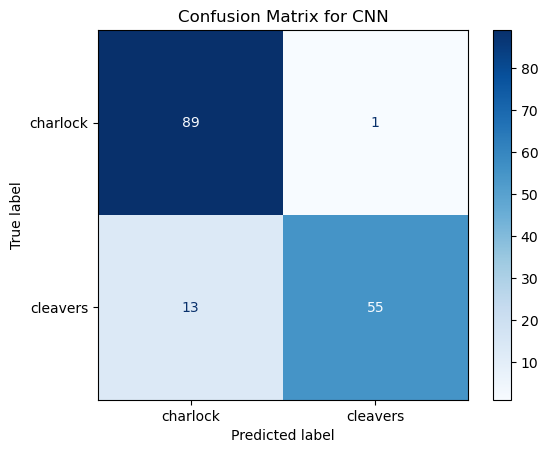

In [26]:
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Define the CNN model
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu')
    ])
    return model

# Define the model input shapes
input_shape = (64, 64, 3)  
num_classes = 2 
num_bins = 8  

# Create the CNN model
cnn_model = create_model(input_shape)

# Define input layer for images
input_img = layers.Input(shape=input_shape)

# Pass input_img through the CNN model
cnn_output = cnn_model(input_img)

# Define input layer for color histogram features
input_hist = layers.Input(shape=(num_bins * 3,))  

# Concatenate CNN output with color histogram features
concatenated = layers.concatenate([cnn_output, input_hist])

# more dense layers for classification
concatenated = layers.Dense(512, activation='relu')(concatenated)
output = layers.Dense(1, activation='sigmoid')(concatenated)

# the final model
model = models.Model(inputs=[input_img, input_hist], outputs=output)

# for model improvement
adam = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
tf.random.set_seed(42)
history_cnn2 = model.fit(
    [train_images, histograms_train], train_labels,
    epochs=15,
    validation_data=([val_images, histograms_val], val_labels),
    shuffle=True,  # Shuffle the training data with a fixed seed
    verbose=1  # Suppress the training output for cleaner display
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([test_images, histograms_test], test_labels)
print('Test accuracy:', test_acc)

# Predict labels for the test set
y_pred = model.predict([test_images, histograms_test]).flatten()
y_pred = np.round(y_pred)

# Print classification report
target_names= ['charlock', 'cleavers']
print(classification_report(test_labels, y_pred, target_names=target_names))

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["charlock", "cleavers"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN')
plt.show()

In [2]:
import pandas as pd
import numpy as np

In [3]:
pd.DataFrame({'Models':['SVM','LOGREG','KNN','FCNN','CNN'],'Train Accuracy(%)':['92.00','93.00','88.00','94.58','97.00'],'Validation Accuracy(%)':['84.45','85.13','81.76','88.50','96.67'],'Test Accuracy(%)':['84.81','88.60','78.48','88.98','96.20']})

,Models,Train Accuracy(%),Validation Accuracy(%),Test Accuracy(%)
0,SVM,92.00,84.45,84.81
1,LOGREG,93.00,85.13,88.60
2,KNN,88.00,81.76,78.48
3,FCNN,94.58,88.50,88.98
4,CNN,97.00,96.67,96.20


References:
https://aileadtech.xyz/course/T6KG4: online training courses 2023

https://www.tensorflow.org/tutorials/images?_gl=1*136p5pz*_up*MQ..*_ga*ODY4ODAyMTA3LjE3MTQ5OTQ3Njg.*_ga_W0YLR4190T*MTcxNTA1MTk0NC4yLjAuMTcxNTA1MTk0NC4wLjAuMA..

https://www.tensorflow.org/tutorials/images/transfer_learning?_gl=1*58ijxr*_up*MQ..*_ga*ODY4ODAyMTA3LjE3MTQ5OTQ3Njg.*_ga_W0YLR4190T*MTcxNTA1MTk0NC4yLjAuMTcxNTA1MTk0NC4wLjAuMA..

https://www.tensorflow.org/tutorials/images/data_augmentation?_gl=1*77vyqs*_up*MQ..*_ga*ODY4ODAyMTA3LjE3MTQ5OTQ3Njg.*_ga_W0YLR4190T*MTcxNTA1MTk0NC4yLjAuMTcxNTA1MTk0NC4wLjAuMA..